In [1]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
import math


# NN
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2, ResNet101V2
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import random

In [2]:
# NORMAL
image_folder_normal = 'chest_xray/chest_xray/train/NORMAL/'

# List all image files in the folder
image_files_normal = sorted([f for f in os.listdir(image_folder_normal) if f.endswith(('jpeg'))])

# Initialize lists to store file names and image data
vec_normal = []
image_arrays_normal = []

# Loop through each image file and process
for image_file in image_files_normal:
    # Load image
    img = Image.open(os.path.join(image_folder_normal, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')

    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_normal.append(img_array)
    vec_normal.append(image_file)

# Create a pandas DataFrame
df_normal = pd.DataFrame({
    'file_name': [image_folder_normal + item for item in vec_normal],
    'image_array': image_arrays_normal,
    'label': 'NORMAL'
})

# BACTERIA

image_folder_pneumonia = 'chest_xray/chest_xray/train/PNEUMONIA/'

# List all image files in the folder
image_files_bacteria = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'bacteria' in f.lower()])

# Initialize lists to store file names and image data
vec_bacteria = []
image_arrays_bacteria = []

# Loop through each image file and process
for image_file in image_files_bacteria:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_bacteria.append(img_array)

    # Append file name and image data to lists
    vec_bacteria.append(image_file)

# Create a pandas DataFrame
df_bacteria = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in vec_bacteria],
    'image_array': image_arrays_bacteria,
    'label': 'BACTERIA'
})

# VIRUS

image_files_virus = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'virus' in f.lower()])

# Initialize lists to store file names and image data
file_names_virus = []
image_arrays_virus = []

# Loop through each image file and process
for image_file in image_files_virus:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_virus.append(img_array)

    # Append file name and image data to lists
    file_names_virus.append(image_file)

# Create a pandas DataFrame
df_virus = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in file_names_virus],
    'image_array': image_arrays_virus,
    'label': 'VIRUS'
})

df_combined = pd.DataFrame({
    'file_name': df_normal['file_name'].tolist() + df_bacteria['file_name'].tolist() + df_virus['file_name'].tolist(),
    'image_array': df_normal['image_array'].tolist() + df_bacteria['image_array'].tolist() + df_virus['image_array'].tolist(),
    'label': df_normal['label'].tolist() + df_bacteria['label'].tolist() + df_virus['label'].tolist()
})

# Data 1

In [60]:
def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/10)*(x-123))

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0

bright_matrix = df_combined['image_array']
X = brightness_f(bright_matrix)
P, W, Y1, Y0 = assign(X)
df_combined['P'] = P
df_combined['W'] = W
df_combined['Y1'] = Y1
df_combined['Y0'] = Y0
df_combined['Y'] = df_combined['W'] * df_combined['Y1'] + (1 - df_combined['W']) * df_combined['Y0']

## NTK

In [115]:

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


N = 5216
X_images = np.array([np.array(x) for x in bright_matrix]).reshape(N, 224, 224, 1)
y_full = df_combined['Y'].values

set_seed(0)
indices = np.arange(N)
train_idx, grad_idx = train_test_split(indices, test_size=0.5, random_state=0)

X_train = X_images[train_idx]
y_train = y_full[train_idx]

X_grad = X_images[grad_idx]
W_grad = W[grad_idx]
Y1_grad = Y1[grad_idx]
Y0_grad = Y0[grad_idx]

X_brightness_grad = X[grad_idx]
Y_grad = y_full[grad_idx]

P_grad = P[grad_idx]



In [ ]:
set_seed(0)

def modeling():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_full = modeling()
model_full.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

model_control = modeling()
model_control.fit(X_train[W[train_idx] == 0], y_full[train_idx][W[train_idx] == 0], epochs=5, batch_size=16, validation_split=0.2)

model_treated = modeling()
model_treated.fit(X_train[W[train_idx] == 1], y_full[train_idx][W[train_idx] == 1], epochs=5, batch_size=16, validation_split=0.2)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.4869 - val_loss: 1.7362
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.2157 - val_loss: 0.1867
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.2277 - val_loss: 0.1874
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.2188 - val_loss: 0.1944
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.2146 - val_loss: 0.1895
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0123 - val_loss: 2.9897
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0076 - val_loss: 0.5477
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0062 - val_loss: 0.1344
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0057 - val_loss: 0.0407
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0055 - val_loss: 0.0164
Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.9429 - val_loss: 9.3974
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0723 

In [7]:

def grad(X, model):
    X_i = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
        prediction = model(X_i, training=True)
    gradients = tape.gradient(prediction, model.trainable_variables)
    gradient_vector = np.concatenate([g.numpy().flatten() for g in gradients if g is not None])
    return gradient_vector


f0_grads = [grad(X_grad[i:i+1], model_control) for i in tqdm(range(len(X_grad)))]
f1_grads = [grad(X_grad[i:i+1], model_treated) for i in tqdm(range(len(X_grad)))]




100%|██████████| 2608/2608 [00:55<00:00, 47.13it/s]


In [ ]:
# AIPW

y_pred = model_full.predict(X_grad)
y_pred_control = model_control.predict(X_grad)
y_pred_treated = model_treated.predict(X_grad)
y_pred = y_pred.flatten()
y_pred_control = y_pred_control.flatten()
y_pred_treated = y_pred_treated.flatten()


In [117]:
n_s =200
np.random.seed(0)
sidx = np.random.choice(len(X_grad), n_s, replace=False)
f0_sampled_grads = [f0_grads[i] for i in sidx]
f1_sampled_grads = [f1_grads[i] for i in sidx]
W_sampled = W_grad[sidx]


# f0_sampled_grads = f0_grads
# f1_sampled_grads = f1_grads
# W_sampled = W_grad
# n_s = len(f0_sampled_grads)

def f0_sampled(i):
    return f0_sampled_grads[i]

def f1_sampled(i):
    return f1_sampled_grads[i]

def K_sampled(i, j):
    if W_sampled[i] == 0 and W_sampled[j] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    elif W_sampled[i] == 1 and W_sampled[j] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

def K_diff_f0_sampled(i, j):
    if W_sampled[i] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    else:
        return 0

def K_diff_f1_sampled(i, j):
    if W_sampled[i] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

K_sampled_XX = np.zeros((n_s, n_s))
K_sampled_TT = np.zeros((n_s, n_s))
K_sampled_CC = np.zeros((n_s, n_s))

for i in range(n_s):
    for j in range(n_s):
        K_sampled_XX[i, j] = K_sampled(i, j)
        K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
        K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)



In [ ]:
I = np.eye(n_s)
lambda1 = 6.944444444444444e-13

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

Wp = np.array([W_grad[i] for i in sidx])
Y1p = np.array([Y1_grad[i] for i in sidx])
Y0p = np.array([Y0_grad[i] for i in sidx])
Xp = np.array([X_brightness_grad[i] for i in sidx])
Yp = Wp * Y1p + (1 - Wp) * Y0p
Pp = np.array([P_grad[i] for i in sidx])
# Pp = np.array([[i] for i in sidx])

# Wp = W_grad
# Y1p = Y1_grad
# Y0p = Y0_grad
# Xp = X_brightness_grad
# Yp = Wp * Y1p + (1 - Wp) * Y0p
# Pp = P[grad_idx]
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)

IPW estimate: 1.0909380515160947


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/4248159403.py:15: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/4248159403.py:16: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


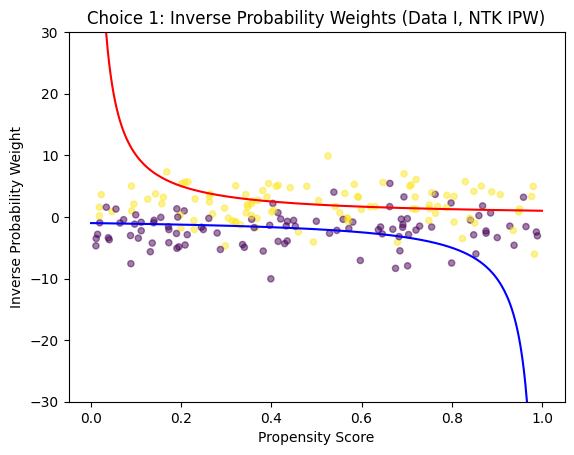

In [110]:

# x = np.array(range(0,220))
# #plt.scatter(Pp, gamma_ntk, c = Wp,alpha = .5, s = 3)
# plt.scatter(Xp, gamma_ntk, c = Wp, alpha = .5, s = 3)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (NTK IPW, Data I)')
# plt.xlabel('Propensity Score')
# plt.ylim(-40,40)
# # save plot as SVG file to a specific directory
    
# plt.savefig('IPW_plot.svg', format='svg', dpi=1200)
# plt.show()

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)


plt.scatter(Pp, gamma_ntk, c = Wp,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data I, NTK IPW)')
plt.ylim(-30, 30)
plt.show()


In [ ]:
# get sampling distribution of the estimator above

import numpy as np
from tqdm import tqdm

n_s = 200
lambda1 = 6.944444444444444e-13
n_bootstrap = 100

ipw_estimates = []
se_hats = []

# Sampled gradients functions defined outside loop
def f0_sampled(i, grads): return grads[i]
def f1_sampled(i, grads): return grads[i]

# Main bootstrap loop
for seed in range(n_bootstrap):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_brightness_grad), n_s, replace=False)

    # Resample relevant data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = np.array([W_grad[i] for i in sidx])
    Y1p = np.array([Y1_grad[i] for i in sidx])
    Y0p = np.array([Y0_grad[i] for i in sidx])
    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    #y_preds = np.array([y_pre[i] for i in sidx])

    # Kernel computation functions scoped for current sample
    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled(i, f0_sampled_grads) @ f0_sampled(j, f0_sampled_grads).T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled(i, f1_sampled_grads) @ f1_sampled(j, f1_sampled_grads).T
        else:
            return 0

    def K_diff_f0_sampled(i, j):
        return f0_sampled(i, f0_sampled_grads) @ f0_sampled(j, f0_sampled_grads).T if W_sampled[i] == 0 else 0

    def K_diff_f1_sampled(i, j):
        return f1_sampled(i, f1_sampled_grads) @ f1_sampled(j, f1_sampled_grads).T if W_sampled[i] == 1 else 0



    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Solve for gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # IPW estimation
    ipw_estimate = np.mean(gamma_optimal * Yp)
    ipw_estimates.append(ipw_estimate)

    # Estimate standard error
    v_sum = gamma_optimal**2 * (Yp - y_pred[sidx]) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hats.append(np.sqrt(v_hat))

# Summary statistics
ipw_estimates = np.array(ipw_estimates)
samplestd_ipw = np.std(ipw_estimates)
exp_se = np.mean(se_hats)
exp_pes = np.mean(ipw_estimates)

# CI coverage (true ATE = 1 assumed)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd_ipw, 1 + 1.96 * samplestd_ipw
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_ipw = np.mean(coverage_flags_ipw)

# Print results
print("Sample SD of IPW estimates:", samplestd_ipw)
print("Mean estimated SE:", exp_se)
print("Mean IPW estimate:", exp_pes)
print("Coverage of 95% CI around true ATE=1:", coverage_ipw)



Sample SD of IPW estimates: 0.029218538928112048
Mean estimated SE: nan
Mean IPW estimate: 1.0962013488433517
Coverage of 95% CI around true ATE=1: 0.08


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


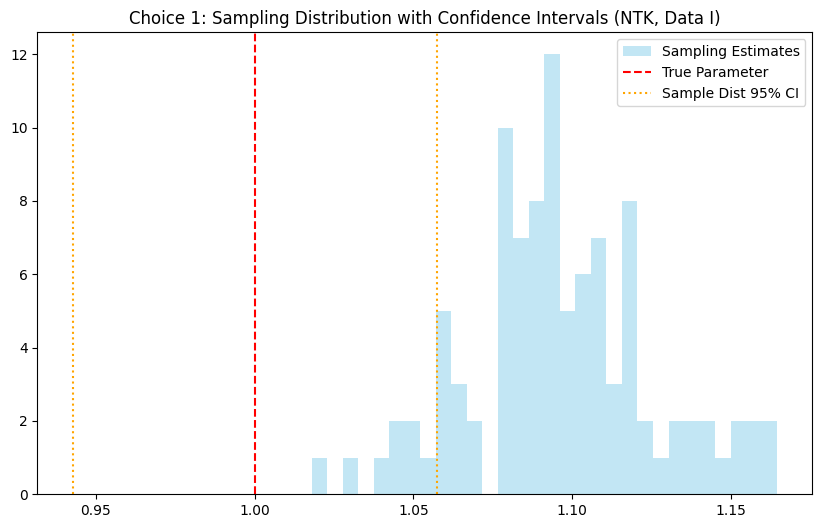

In [114]:
plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (NTK, Data I)')

plt.legend()
plt.show()

In [128]:
#### SECOND Choice

I = np.eye(n_s)
lambda1 = 5.37914353639919e-11

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

Wp = np.array([W_grad[i] for i in sidx])
Y1p = np.array([Y1_grad[i] for i in sidx])
Y0p = np.array([Y0_grad[i] for i in sidx])
Xp = np.array([X_brightness_grad[i] for i in sidx])
Yp = Wp * Y1p + (1 - Wp) * Y0p
Pp = np.array([P_grad[i] for i in sidx])
# Pp = np.array([[i] for i in sidx])

# Wp = W_grad
# Y1p = Y1_grad
# Y0p = Y0_grad
# Xp = X_brightness_grad
# Yp = Wp * Y1p + (1 - Wp) * Y0p
# Pp = P[grad_idx]
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)

IPW estimate: 1.122845924886907


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/3350713287.py:15: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/3350713287.py:16: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


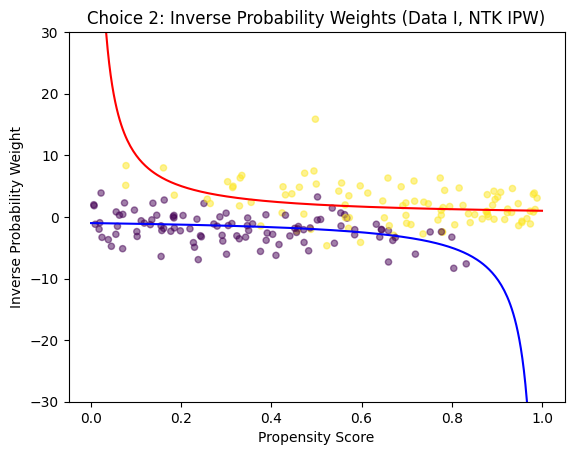

In [129]:

# x = np.array(range(0,220))
# #plt.scatter(Pp, gamma_ntk, c = Wp,alpha = .5, s = 3)
# plt.scatter(Xp, gamma_ntk, c = Wp, alpha = .5, s = 3)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (NTK IPW, Data I)')
# plt.xlabel('Propensity Score')
# plt.ylim(-40,40)
# # save plot as SVG file to a specific directory
    
# plt.savefig('IPW_plot.svg', format='svg', dpi=1200)
# plt.show()

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)


plt.scatter(Pp, gamma_ntk, c = Wp,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data I, NTK IPW)')
plt.ylim(-30, 30)
plt.show()


In [132]:
# get sampling distribution of the estimator above
n_s = 200
lambda1 = 5.37914353639919e-11
n_bootstrap = 100

ipw_estimates = []
se_hats = []

# Sampled gradients functions defined outside loop
def f0_sampled(i, grads): return grads[i]
def f1_sampled(i, grads): return grads[i]

# Main bootstrap loop
for seed in range(n_bootstrap):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_brightness_grad), n_s, replace=False)

    # Resample relevant data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = np.array([W_grad[i] for i in sidx])
    Y1p = np.array([Y1_grad[i] for i in sidx])
    Y0p = np.array([Y0_grad[i] for i in sidx])
    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    #y_preds = np.array([y_pre[i] for i in sidx])

    # Kernel computation functions scoped for current sample
    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled(i, f0_sampled_grads) @ f0_sampled(j, f0_sampled_grads).T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled(i, f1_sampled_grads) @ f1_sampled(j, f1_sampled_grads).T
        else:
            return 0

    def K_diff_f0_sampled(i, j):
        return f0_sampled(i, f0_sampled_grads) @ f0_sampled(j, f0_sampled_grads).T if W_sampled[i] == 0 else 0

    def K_diff_f1_sampled(i, j):
        return f1_sampled(i, f1_sampled_grads) @ f1_sampled(j, f1_sampled_grads).T if W_sampled[i] == 1 else 0

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Solve for gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # IPW estimation
    ipw_estimate = np.mean(gamma_optimal * Yp)
    ipw_estimates.append(ipw_estimate)

    # Estimate standard error
    v_sum = gamma_optimal**2 * (Yp - y_pred[sidx]) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hats.append(np.sqrt(v_hat))

# Summary statistics
ipw_estimates = np.array(ipw_estimates)
samplestd_ipw = np.std(ipw_estimates)
exp_se = np.mean(se_hats)
exp_pes = np.mean(ipw_estimates)

# CI coverage (true ATE = 1 assumed)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd_ipw, 1 + 1.96 * samplestd_ipw
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_ipw = np.mean(coverage_flags_ipw)

# Print results
print("Sample SD of IPW estimates:", samplestd_ipw)
print("Mean estimated SE:", exp_se)
print("Mean IPW estimate:", exp_pes)
print("Coverage of 95% CI around true ATE=1:", coverage_ipw)



Sample SD of IPW estimates: 0.030104454348731182
Mean estimated SE: 0.14033626562632404
Mean IPW estimate: 1.1008170586271961
Coverage of 95% CI around true ATE=1: 0.06


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (NTK, Data I)')

plt.legend()
plt.show()

# AIPW

In [120]:
lambda1 = 1000

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

# Compute AIPW Estimate
bias_term = np.mean(y_pred_treated[sidx] - y_pred_control[sidx])
pred_term = np.mean(gamma_ntk * (Yp- y_pred[sidx]))
AIPW = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_ntk * (Yp - y_pred[sidx]))

#AIPW = np.mean(y_pred_treated[sidx] - y_pred_control[sidx])+np.mean(gamma_ntk * (Yp - y_pred[sidx]))
print(bias_term)
print(pred_term)
print("AIPW estimate:", AIPW)
v_sum = gamma_ntk**2 * (Yp - y_pred[sidx]) ** 2
v_hat = (1 / n_s**2) * np.sum(v_sum)
se_hat = np.sqrt(v_hat)
print("Standard error estimate:", se_hat)

1.4281931
0.5096038359876303
AIPW estimate: 1.9377969283338217
Standard error estimate: 0.04976893801654576


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/1983950398.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_78340/1983950398.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


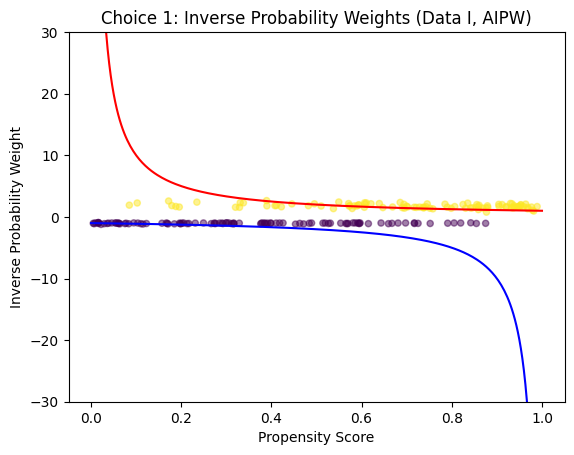

In [121]:
# x = np.array(range(0,220))
# plt.scatter(Xp, gamma_ntk, c = Wp,alpha = .5, s = 5)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (NTK AIPW, Data I)')
# plt.ylim(-20,20)

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)


plt.scatter(Pp, gamma_ntk, c = Wp,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data I, AIPW)')
plt.ylim(-30, 30)
plt.show()

$\lambda_{IPW} = 3.227486121839514e-07$



### AIPWs

In [123]:
n_s = 200
lambda1 = 13500
#ipw_estimates = []
aipw_estimates = [] 
se_hats = []

for seed in range(100):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_brightness_grad), n_s, replace=False)

    # Get sampled gradients and data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W[sidx]

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Compute optimal gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # Estimate IPW
    Wp = np.array([W_grad[i] for i in sidx])
    Y1p = np.array([Y1_grad[i] for i in sidx])
    Y0p = np.array([Y0_grad[i] for i in sidx])
    Yp = Wp * Y1p + (1 - Wp) * Y0p

    #ipw_estimate = np.mean(gamma_optimal * Yp)
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
    #ipw_estimates.append(ipw_estimate)
    aipw_estimates.append(aipw_estimate)

    y_preds = np.array([y_pred[i] for i in sidx])
    v_sum = gamma_optimal**2 * (Yp - y_preds) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_hats.append(se_hat)

#samplestd_ipw = np.std(ipw_estimates)
samplestd_aipw = np.std(aipw_estimates)
exp_se = np.mean(se_hats)
exp_pes = np.mean(aipw_estimates)
true_arm_l, true_arm_r = 1 - 1.96*samplestd_aipw, 1+1.96*samplestd_aipw
#coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_flags_aipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
#coverage_ipw = np.mean(coverage_flags_ipw)
coverage_aipw = np.mean(coverage_flags_aipw)

#print("sample sd of IPW estimates:", samplestd_ipw)
print("sample sd of AIPW estimates:", samplestd_aipw)
print("Mean standard error estimate:", exp_se)
#print("Coverage of confidence intervals:", coverage_ipw)
print("Coverage of AIPW confidence intervals:", coverage_aipw)
#print("Mean IPW estimate:", exp_pes)
print("Mean AIPW estimate:", np.mean(aipw_estimates))


sample sd of AIPW estimates: 0.017014744233520167
Mean standard error estimate: 0.01430732376392761
Coverage of AIPW confidence intervals: 0.0
Mean AIPW estimate: 1.4601719570953187


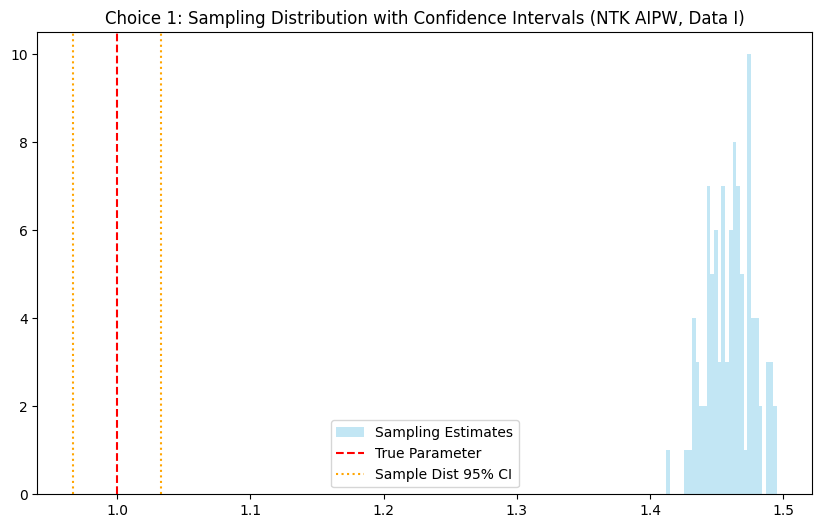

In [124]:
plt.figure(figsize=(10, 6))
plt.hist(aipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (NTK AIPW, Data I)')

plt.legend()
plt.show()

In [125]:
n_s = 200
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]
results = []
ses = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigma = 1

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigma**2/(Bs**2 * n_s**2)
    ipw_estimates = []
    se_hats = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(len(X_brightness_grad), n_s, replace=False)

        # Sample gradients
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W_grad[sidx]

        # Kernel matrices
        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

        # Solve for gamma
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        # IPW estimate
        Wp = np.array([W_grad[i] for i in sidx])
        Y1p = np.array([Y1_grad[i] for i in sidx])
        Y0p = np.array([Y0_grad[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        ipw_estimate = np.mean(gamma_optimal * Yp)
        ipw_estimates.append(ipw_estimate)

        # Variance estimate
        y_preds = np.array([y_pred[i] for i in sidx])
        v_sum = gamma_optimal**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    # Summary stats for this k
    samplestd = np.std(ipw_estimates)
    exp_se = np.mean(se_hats)
    exp_pes = np.mean(ipw_estimates)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1 + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
    coverage = np.mean(coverage_flags)
    rmse = np.sqrt(np.mean((np.array(ipw_estimates) - 1)**2))
    bias = np.mean(ipw_estimates) - 1



    print('p:', k)
    print('lambda:', lambda1)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exp_pes)
    print('rmse:', rmse)
    print('bias:', bias)
    print('---')

    ses.append(samplestd)
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)

    



p: -1
lambda: 900.0
coverage: 0.0
sample std: 0.027398644666449624
expected pes: 1.2780943521519574
rmse: 0.27944078876995604
bias: 0.27809435215195744
---
p: -0.75
lambda: 11.618950038622252
coverage: 0.0
sample std: 0.026346831961447697
expected pes: 1.2897723371237604
rmse: 0.29096763207712784
bias: 0.2897723371237604
---
p: -0.5
lambda: 0.15000000000000002
coverage: 0.0
sample std: 0.02378175243108577
expected pes: 1.1673903844391358
rmse: 0.16907132385882323
bias: 0.1673903844391358
---
p: -0.25
lambda: 0.0019364916731037087
coverage: 0.03
sample std: 0.02775716585686776
expected pes: 1.1091740624106807
rmse: 0.11264739748283963
bias: 0.10917406241068073
---
p: 0
lambda: 2.5e-05
coverage: 0.05
sample std: 0.030030849812993126
expected pes: 1.1009980969860031
rmse: 0.10536824728201886
bias: 0.10099809698600315
---
p: 0.25
lambda: 3.227486121839514e-07
coverage: 0.06
sample std: 0.030103483844085795
expected pes: 1.1008194241812643
rmse: 0.10521775530675813
bias: 0.10081942418126433

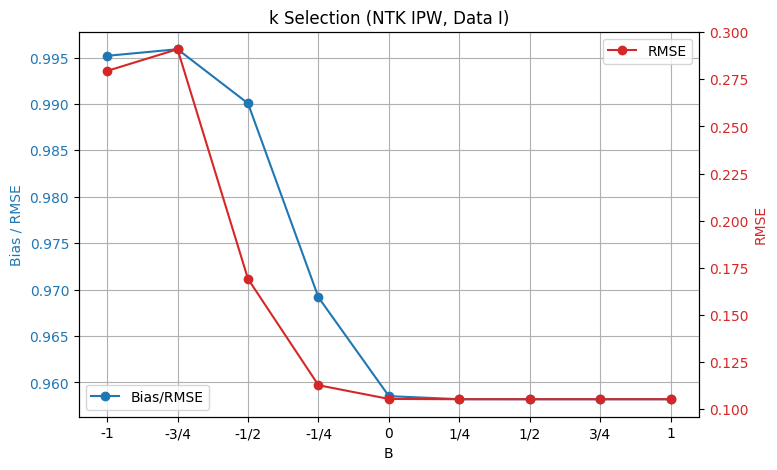

In [126]:
biasoverrmse = np.array(biasv)/np.array(rmses)  

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('B')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.legend(loc='lower left')
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])

# Secondary y-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('RMSE', color=color2)
ax2.plot(np.log(Bsv), rmses, marker='o', color=color2, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend()

# Title, grid, and layout
plt.title('k Selection (NTK IPW, Data I)')
ax1.grid(True)
plt.legend()
plt.show()

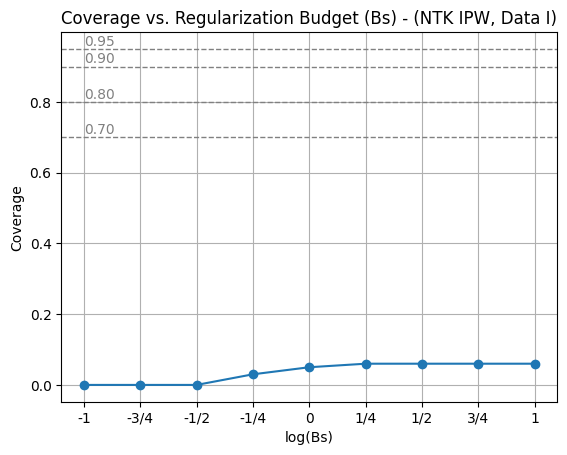

In [127]:
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')

# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK IPW, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])
plt.show()


In [ ]:
n_s = 200
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]
results = []
ses = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigmasquared = 15

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigmasquared/(Bs**2 * n_s**2)
    aipw_estimates = []
    se_hats = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(N, n_s, replace=False)

        # Sample gradients
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W[sidx]

        # Kernel matrices
        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

        # Solve for gamma
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        # IPW estimate
        Wp = np.array([W[i] for i in sidx])
        Y1p = np.array([Y1[i] for i in sidx])
        Y0p = np.array([Y0[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
        aipw_estimates.append(aipw_estimate)

        # Variance estimate
        y_preds = np.array([y_pred[i] for i in sidx])
        v_sum = gamma_optimal**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    # Summary stats for this k
    samplestd = np.std(aipw_estimates)
    exp_se = np.mean(se_hats)
    exp_pes = np.mean(aipw_estimates)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1 + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
    coverage = np.mean(coverage_flags)
    rmse = np.sqrt(np.mean((np.array(aipw_estimates) - 1)**2))
    bias = np.abs(np.mean(aipw_estimates) - 1)



    print('p:', k)
    print('lambda:', lambda1)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exp_pes)
    print('rmse:', rmse)
    print('bias:', bias)
    print('---')

    ses.append(samplestd)
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)

    



p: -1
lambda: 13500.0
coverage: 0.0
sample std: 0.010654257690585287
expected pes: 1.2991754200202161
rmse: 0.2993650700252285
bias: 0.29917542002021613
---
p: -0.75
lambda: 174.2842505793338
coverage: 0.0
sample std: 0.03653168798425026
expected pes: 1.8106691122890686
rmse: 0.8114918199504694
bias: 0.8106691122890686
---
p: -0.5
lambda: 2.25
coverage: 0.0
sample std: 0.03631115726060212
expected pes: 1.9598144457226012
rmse: 0.9605010517221666
bias: 0.9598144457226012
---
p: -0.25
lambda: 0.02904737509655563
coverage: 0.0
sample std: 0.03100210732227533
expected pes: 2.07978569868013
rmse: 1.0802306632069647
bias: 1.07978569868013
---
p: 0
lambda: 0.000375
coverage: 0.0
sample std: 0.03232027231376848
expected pes: 2.123742947399283
rmse: 1.124207637330428
bias: 1.123742947399283
---
p: 0.25
lambda: 4.8412291827592715e-06
coverage: 0.0
sample std: 0.034037749295772614
expected pes: 2.1290700173336945
rmse: 1.1295829639380326
bias: 1.1290700173336945
---
p: 0.5
lambda: 6.25e-08
covera

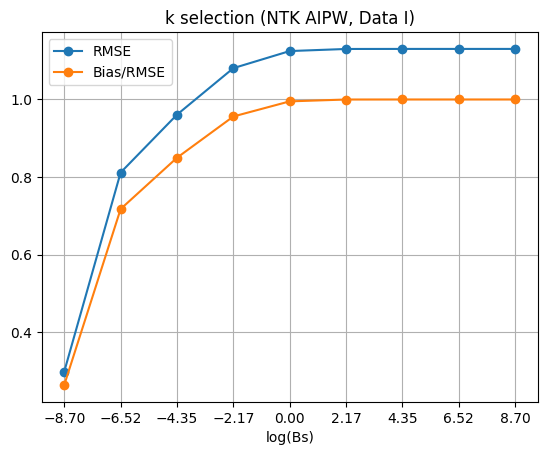

In [101]:
plt.plot(np.log(Bsv), rmses, marker='o', label='RMSE')
plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
plt.title('k selection (NTK AIPW, Data I)')
plt.xlabel('log(Bs)')
plt.xticks(np.log(Bsv))
plt.grid()
plt.legend()
plt.show()

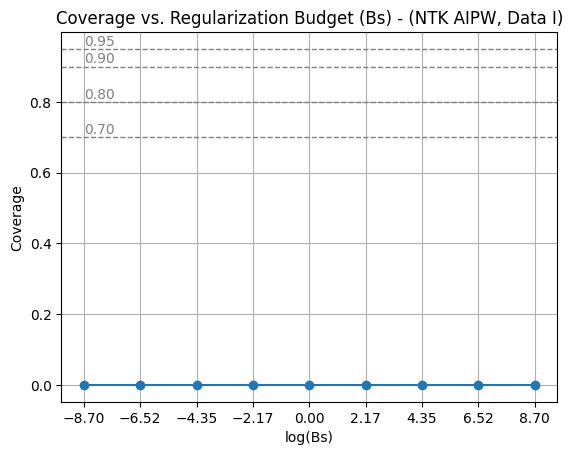

In [102]:
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')

# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK AIPW, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv))
plt.show()


# Data 2

In [214]:
def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/15)*(x-123))

def assign_by_group(x, l):
  
    beta0 = -5
    beta1 = 1
    beta2 = 1
    beta3 = -1

    Xl_i = beta0 + beta1 * x + beta2 * (l == 'BACTERIA') + beta3 * (l == 'VIRUS')
    p_i = propensity_score(Xl_i)
    np.random.seed(0)
    w_i = np.random.binomial(1, p_i)

    gamma_0 = 0
    
    gammas = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', -1, -1))
    taus = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', 1, -1))

    y_0 = gamma_0 + gammas + p_i
    y_1 = gamma_0 + gammas + p_i + taus

    return p_i, w_i, y_1, y_0

L = df_combined['label']

P, W, Y1, Y0 = assign_by_group(X, L)
df_combined['W'] = W
df_combined['Y1'] = Y1
df_combined['Y0'] = Y0
df_combined['Y'] = df_combined['W'] * df_combined['Y1'] + (1 - df_combined['W']) * df_combined['Y0']

df_control = df_combined[df_combined['W'] == 0]
df_treated = df_combined[df_combined['W'] == 1]
X_full = np.array([np.array(x) for x in bright_matrix])
y_full = df_combined['Y'].values
X_control = np.array([np.array(x) for x in df_control['image_array']])
y_control = df_control['Y'].values
X_treated = np.array([np.array(x) for x in df_treated['image_array']])
y_treated = df_treated['Y'].values



In [217]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Concatenate

# Set constants
set_seed(0)
N = 5216

# Step 1: Create a shuffled index split
indices = np.arange(N)
train_idx, grad_idx = train_test_split(indices, test_size=0.5, random_state=0)

# Step 2: Split everything using these indices

# Image + outcome data
X_train = X_full[train_idx]
y_train = y_full[train_idx]
X_grad = X_full[grad_idx]
y_grad = y_full[grad_idx]

# For control/treated models
X_control = X_train[W[train_idx] == 0]
X_treated = X_train[W[train_idx] == 1]
y_control = y_train[W[train_idx] == 0]
y_treated = y_train[W[train_idx] == 1]

# Full DataFrame for labels and metadata
df_train = df_combined.iloc[train_idx]
df_grad = df_combined.iloc[grad_idx]

# Encode labels
ohe = OneHotEncoder(sparse_output=False)
L_encoded_train = ohe.fit_transform(df_train[['label']])
L_encoded_grad = ohe.transform(df_grad[['label']])  # important to use transform here, not fit_transform

# Subsets for control/treated with label inputs
X_control_input = [X_control, L_encoded_train[df_train['W'].values == 0]]
X_treated_input = [X_treated, L_encoded_train[df_train['W'].values == 1]]
X_full_input = [X_train, L_encoded_train]

# Set seed
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(0)

# Define model
def modeling_with_label():
    image_input = Input(shape=(224, 224, 1))
    label_input = Input(shape=(3,))

    x = Conv2D(16, (3, 3), activation='relu')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    x = Concatenate()([x, label_input])
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[image_input, label_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train models
model_full = modeling_with_label()
model_full.fit(X_full_input, y_train, epochs=5, batch_size=16, validation_split=0.2)

model_control = modeling_with_label()
model_control.fit(X_control_input, y_control, epochs=5, batch_size=16, validation_split=0.2)

model_treated = modeling_with_label()
model_treated.fit(X_treated_input, y_treated, epochs=5, batch_size=16, validation_split=0.2)

# Predict on training set
y_pred = model_full.predict(X_full_input).flatten()
y_pred_control = model_control.predict(X_control_input).flatten()
y_pred_treated = model_treated.predict(X_treated_input).flatten()


Epoch 1/5


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1115', 'keras_tensor_1116']. Received: the structure of inputs=('*', '*')
  warnings.warn(


131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.3865 - val_loss: 0.3552
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1826 - val_loss: 0.2117
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - loss: 0.1680 - val_loss: 0.1611
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.1645 - val_loss: 0.1432
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.1633 - val_loss: 0.1343
Epoch 1/5


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1125', 'keras_tensor_1126']. Received: the structure of inputs=('*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - loss: 0.2078 - val_loss: 0.5904
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0099 - val_loss: 0.1828
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0075 - val_loss: 0.0608
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0066 - val_loss: 0.0286
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0060 - val_loss: 0.0150
Epoch 1/5


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1135', 'keras_tensor_1136']. Received: the structure of inputs=('*', '*')
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - loss: 0.5304 - val_loss: 0.1939
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.1667 - val_loss: 0.1176
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0457 - val_loss: 0.0705
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0142 - val_loss: 0.0469
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0079 - val_loss: 0.0123
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [219]:

def grad(i, model, X_images, X_labels):
    # Convert a single sample
    image_input = tf.convert_to_tensor(X_images[i:i+1], dtype=tf.float32)
    label_input = tf.convert_to_tensor(X_labels[i:i+1], dtype=tf.float32)

    with tf.GradientTape() as tape:
        prediction = model([image_input, label_input], training=True)
    gradients = tape.gradient(prediction, model.trainable_variables)
    
    # Flatten and concatenate all gradients into a single vector
    gradient_vector = np.concatenate([
        g.numpy().flatten() for g in gradients if g is not None
    ])
    return gradient_vector


f0_grads = [grad(i, model_control, X_grad, L_encoded_grad) for i in tqdm(grad_idx)]
f1_grads = [grad(i, model_treated, X_grad, L_encoded_grad) for i in tqdm(grad_idx)]



n_s = 200
np.random.seed(0)
sidx = np.random.choice(N, n_s, replace=False)
f0_sampled_grads = [f0_grads[i] for i in sidx]
f1_sampled_grads = [f1_grads[i] for i in sidx]
W_sampled = W[sidx]

def f0_sampled(i):
    return f0_sampled_grads[i]

def f1_sampled(i):
    return f1_sampled_grads[i]

def K_sampled(i, j):
    if W_sampled[i] == 0 and W_sampled[j] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    elif W_sampled[i] == 1 and W_sampled[j] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

def K_diff_f0_sampled(i, j):
    if W_sampled[i] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    else:
        return 0

def K_diff_f1_sampled(i, j):
    if W_sampled[i] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

K_sampled_XX = np.zeros((n_s, n_s))
K_sampled_TT = np.zeros((n_s, n_s))
K_sampled_CC = np.zeros((n_s, n_s))

for i in range(n_s):
    for j in range(n_s):
        K_sampled_XX[i, j] = K_sampled(i, j)
        K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
        K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)



  0%|          | 1/2608 [00:00<07:40,  5.66it/s]

: 

In [180]:
I = np.eye(n_s)
lambda1 = 2.5e-05

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

Wp = np.array([W[i] for i in sidx])
Y1p = np.array([Y1[i] for i in sidx])
Y0p = np.array([Y0[i] for i in sidx])
Xp = np.array([X[i] for i in sidx])

# IPW

# Compute IPW Estimate
Yp = Wp * Y1p + (1 - Wp) * Y0p
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)



IPW estimate: 0.2963232749438538


(-40.0, 40.0)

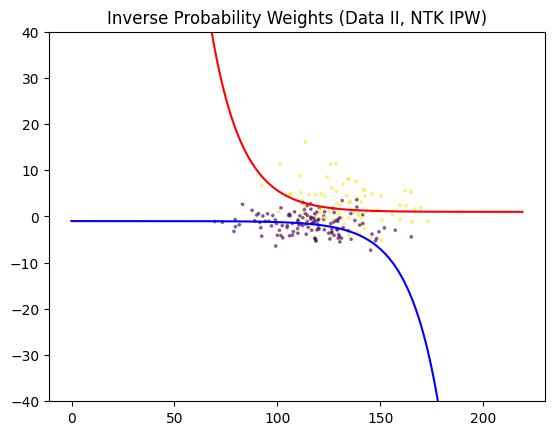

In [181]:
x = np.array(range(0,220))
plt.scatter(Xp, gamma_ntk, c = Wp,alpha = .5, s = 3)
plt.plot(x, 1/(propensity_score(x)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
plt.title('Inverse Probability Weights (Data II, NTK IPW)')
plt.ylim(-40,40)

In [182]:
I = np.eye(n_s)
lambda1 = 13500.0

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()


AIPW = np.mean(y_pred_treated[sidx] - y_pred_control[sidx])+np.mean(gamma_ntk * (Yp - y_pred[sidx]))

print("AIPW estimate:", AIPW)

y_preds = np.array([y_pred[i] for i in sidx])
v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
v_hat = (1 / n_s**2) * np.sum(v_sum)
se_hat = np.sqrt(v_hat)
print("Standard error estimate:", se_hat)

AIPW estimate: 0.7313615404351608
Standard error estimate: 0.02233326086926277


(-40.0, 40.0)

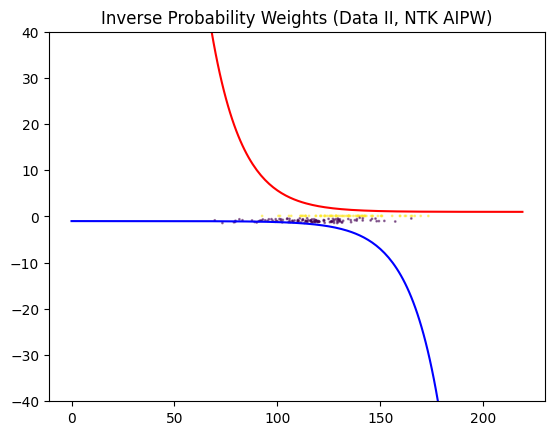

In [183]:
x = np.array(range(0,220))
plt.scatter(Xp, gamma_ntk, c = Wp,alpha = .5, s = 1)
plt.plot(x, 1/(propensity_score(x)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
plt.title('Inverse Probability Weights (Data II, NTK AIPW)')
plt.ylim(-40,40)

In [184]:


true = 0.227
print('true:', true)

true: 0.227


In [185]:
n_s = 200
lambda1 = 2.5e-05
ipw_estimates = []
se_hats = []

for seed in range(100):
    np.random.seed(seed)
    sidx = np.random.choice(N, n_s, replace=False)

    # Get sampled gradients and data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W[sidx]

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Compute optimal gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # Estimate IPW
    Wp = np.array([W[i] for i in sidx])
    Y1p = np.array([Y1[i] for i in sidx])
    Y0p = np.array([Y0[i] for i in sidx])
    Yp = Wp * Y1p + (1 - Wp) * Y0p

    ipw_estimate = np.mean(gamma_optimal * Yp)
    #aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
    ipw_estimates.append(ipw_estimate)
    #aipw_estimates.append(aipw_estimate)

    y_preds = np.array([y_pred[i] for i in sidx])
    v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_hats.append(se_hat)

samplestd_ipw = np.std(ipw_estimates)
#samplestd_aipw = np.std(aipw_estimates)
exp_se = np.mean(se_hats)
exp_pes = np.mean(ipw_estimates)
true_arm_l, true_arm_r =  true- 1.96*samplestd_ipw, true+1.96*samplestd_ipw
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
#coverage_flags_aipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
coverage_ipw = np.mean(coverage_flags_ipw)
#coverage_aipw = np.mean(coverage_flags_aipw)

print("sample sd of IPW estimates:", samplestd_ipw)
#print("sample sd of AIPW estimates:", samplestd_aipw)
print("Mean standard error estimate:", exp_se)
print("Coverage of confidence intervals:", coverage_ipw)
#print("Coverage of AIPW confidence intervals:", coverage_aipw)
print("Mean IPW estimate:", exp_pes)
#print("Mean AIPW estimate:", np.mean(aipw_estimates))


sample sd of IPW estimates: 0.14245424881897356
Mean standard error estimate: 0.03443041772252275
Coverage of confidence intervals: 0.87
Mean IPW estimate: 0.32565967231359993


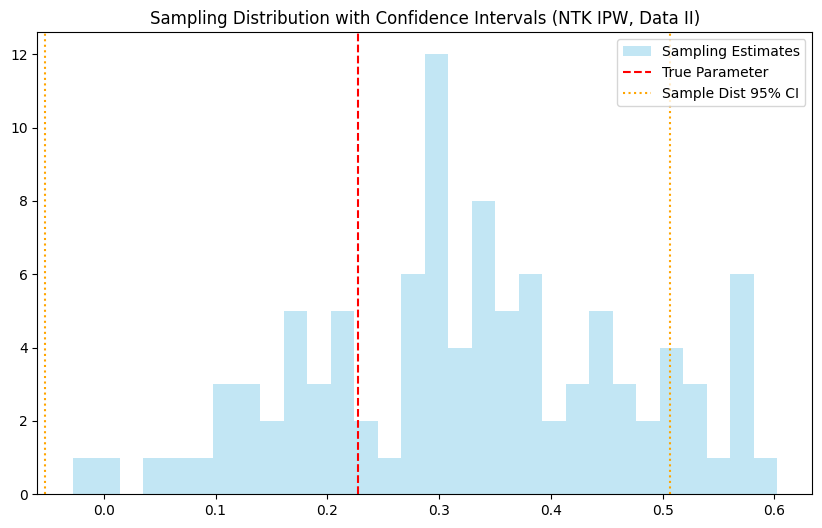

In [186]:
plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Sampling Distribution with Confidence Intervals (NTK IPW, Data II)')

plt.legend()
plt.show()


In [187]:
n_s = 200
lambda1 = 13500.0
aipw_estimates = [] 
se_hats = []

for seed in range(100):
    np.random.seed(seed)
    sidx = np.random.choice(N, n_s, replace=False)

    # Get sampled gradients and data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W[sidx]

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Compute optimal gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # Estimate IPW
    Wp = np.array([W[i] for i in sidx])
    Y1p = np.array([Y1[i] for i in sidx])
    Y0p = np.array([Y0[i] for i in sidx])
    Yp = Wp * Y1p + (1 - Wp) * Y0p

    #ipw_estimate = np.mean(gamma_optimal * Yp)
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
    #ipw_estimates.append(ipw_estimate)
    aipw_estimates.append(aipw_estimate)

    y_preds = np.array([y_pred[i] for i in sidx])
    v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_hats.append(se_hat)

#samplestd_ipw = np.std(ipw_estimates)
samplestd_aipw = np.std(aipw_estimates)
exp_se = np.mean(se_hats)
#exp_pes = np.mean(ipw_estimates)
true_arm_l, true_arm_r =  true- 1.96*samplestd_aipw, true+1.96*samplestd_aipw
#coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_flags_aipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
#coverage_ipw = np.mean(coverage_flags_ipw)
coverage_aipw = np.mean(coverage_flags_aipw)

#print("sample sd of IPW estimates:", samplestd_ipw)
print("sample sd of AIPW estimates:", samplestd_aipw)
print("Mean standard error estimate:", exp_se)
#print("Coverage of confidence intervals:", coverage_ipw)
print("Coverage of AIPW confidence intervals:", coverage_aipw)
#print("Mean IPW estimate:", exp_pes)
print("Mean AIPW estimate:", np.mean(aipw_estimates))


sample sd of AIPW estimates: 0.03193807580796349
Mean standard error estimate: 0.03443041772252275
Coverage of AIPW confidence intervals: 0.0
Mean AIPW estimate: 0.734523049223534


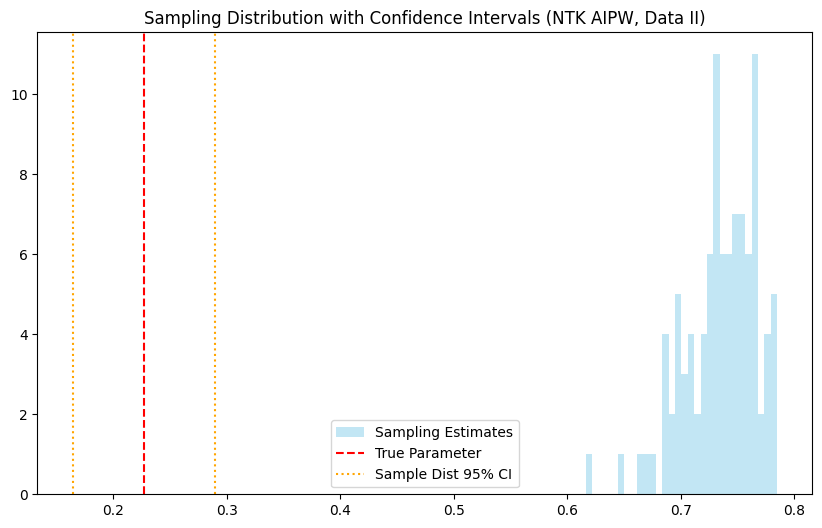

In [188]:
plt.figure(figsize=(10, 6))
plt.hist(aipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Sampling Distribution with Confidence Intervals (NTK AIPW, Data II)')

plt.legend()
plt.show()

In [115]:
n_s = 200
results = []
ses = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigma = 1
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigma**2/(Bs**2 * n_s**2)
    ipw_estimates = []
    se_hats = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(N, n_s, replace=False)

        # Sample gradients
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W[sidx]

        # Kernel matrices
        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

        # Solve for gamma
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        # IPW estimate
        Wp = np.array([W[i] for i in sidx])
        Y1p = np.array([Y1[i] for i in sidx])
        Y0p = np.array([Y0[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        ipw_estimate = np.mean(gamma_optimal * Yp)
        ipw_estimates.append(ipw_estimate)

        # Variance estimate
        y_preds = np.array([y_pred[i] for i in sidx])
        v_sum = gamma_optimal**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    # Summary stats for this k
    samplestd = np.std(ipw_estimates)
    exp_se = np.mean(se_hats)
    exp_pes = np.mean(ipw_estimates)
    true_arm_l, true_arm_r = true - 1.96*samplestd, true + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
    coverage = np.mean(coverage_flags)
    rmse = np.sqrt(np.mean((np.array(ipw_estimates) - true)**2))
    bias = np.abs(np.mean(ipw_estimates) - true)

    print('p:', k)
    print('lambda:', lambda1)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exp_pes)
    print('---')

    ses.append(samplestd)
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)
    


p: -1
lambda: 900.0
coverage: 0.51
sample std: 0.06252429206291055
expected pes: 0.34827839887304196
---
p: -0.75
lambda: 11.618950038622252
coverage: 0.58
sample std: 0.10090312861267589
expected pes: 0.41050598118701964
---
p: -0.5
lambda: 0.15000000000000002
coverage: 0.76
sample std: 0.10276361518261522
expected pes: 0.3581986878472978
---
p: -0.25
lambda: 0.0019364916731037087
coverage: 0.84
sample std: 0.132063045343609
expected pes: 0.3310402168638781
---
p: 0
lambda: 2.5e-05
coverage: 0.87
sample std: 0.14245424881897356
expected pes: 0.32565967231359993
---
p: 0.25
lambda: 3.227486121839514e-07
coverage: 0.87
sample std: 0.14265264544513107
expected pes: 0.32556666105971055
---
p: 0.5
lambda: 4.166666666666667e-09
coverage: 0.87
sample std: 0.14265522334310954
expected pes: 0.3255654545031607
---
p: 0.75
lambda: 5.37914353639919e-11
coverage: 0.87
sample std: 0.14265525662670542
expected pes: 0.32556543892575773
---
p: 1
lambda: 6.944444444444444e-13
coverage: 0.87
sample std:

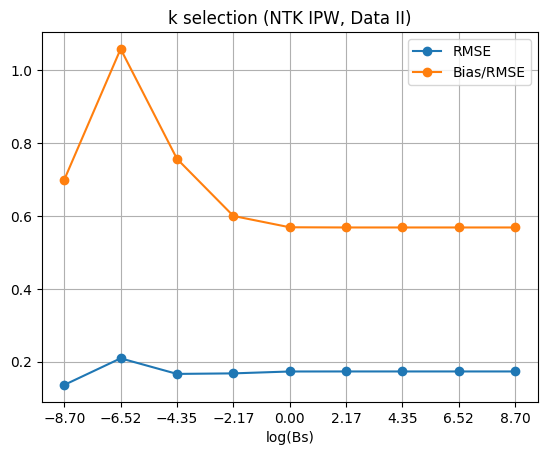

In [116]:
plt.plot(np.log(Bsv), rmses, marker='o', label='RMSE')
plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
plt.title('k selection (NTK IPW, Data II)')
plt.xlabel('log(Bs)')
plt.xticks(np.log(Bsv))
plt.grid()
plt.legend()
plt.show()


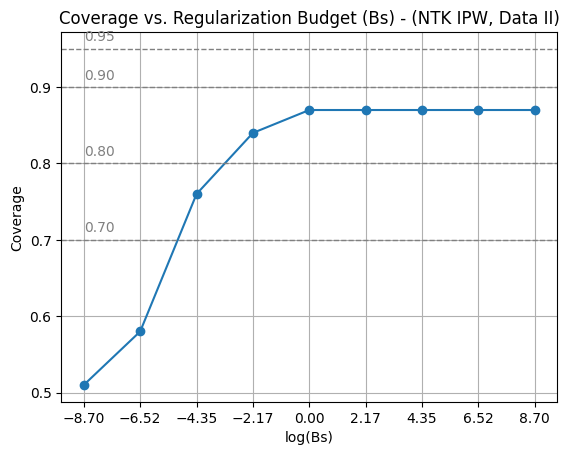

In [117]:
# coverage

plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK IPW, Data II)')
plt.grid(True)
plt.xticks(np.log(Bsv))
plt.show()


In [118]:
# aipw

n_s = 200
results = []
ses = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigmasquared = 15
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigmasquared/(Bs**2 * n_s**2)
    aipw_estimates = []
    se_hats = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(N, n_s, replace=False)

        # Sample gradients
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W[sidx]

        # Kernel matrices
        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

        # Solve for gamma
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        # IPW estimate
        Wp = np.array([W[i] for i in sidx])
        Y1p = np.array([Y1[i] for i in sidx])
        Y0p = np.array([Y0[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
        aipw_estimates.append(aipw_estimate)

        # Variance estimate
        y_preds = np.array([y_pred[i] for i in sidx])
        v_sum = gamma_optimal**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    # Summary stats for this k
    samplestd = np.std(aipw_estimates)
    exp_se = np.mean(se_hats)
    exp_pes = np.mean(aipw_estimates)
    true_arm_l, true_arm_r = true - 1.96*samplestd, true + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
    coverage = np.mean(coverage_flags)
    rmse = np.sqrt(np.mean((np.array(aipw_estimates) - true)**2))
    bias = np.abs(np.mean(aipw_estimates) - true)

    print('p:', k)
    print('lambda:', lambda1)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exp_pes)
    print('---')

    ses.append(samplestd)
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)
    


p: -1
lambda: 13500.0
coverage: 0.0
sample std: 0.03193807580796349
expected pes: 0.734523049223534
---
p: -0.75
lambda: 174.2842505793338
coverage: 0.0
sample std: 0.09245358338508602
expected pes: 0.7395141806922968
---
p: -0.5
lambda: 2.25
coverage: 0.0
sample std: 0.10636383114631048
expected pes: 0.7783625195891608
---
p: -0.25
lambda: 0.02904737509655563
coverage: 0.0
sample std: 0.11658752345625285
expected pes: 0.8569278512888965
---
p: 0
lambda: 0.000375
coverage: 0.0
sample std: 0.14349623292490518
expected pes: 0.8594960654945112
---
p: 0.25
lambda: 4.8412291827592715e-06
coverage: 0.0
sample std: 0.14611847981312515
expected pes: 0.8590757882743592
---
p: 0.5
lambda: 6.25e-08
coverage: 0.0
sample std: 0.14615575238820241
expected pes: 0.8590697347404348
---
p: 0.75
lambda: 8.068715304598785e-10
coverage: 0.0
sample std: 0.14615623420933552
expected pes: 0.8590696564737081
---
p: 1
lambda: 1.0416666666666666e-11
coverage: 0.0
sample std: 0.1461562404295109
expected pes: 0.85

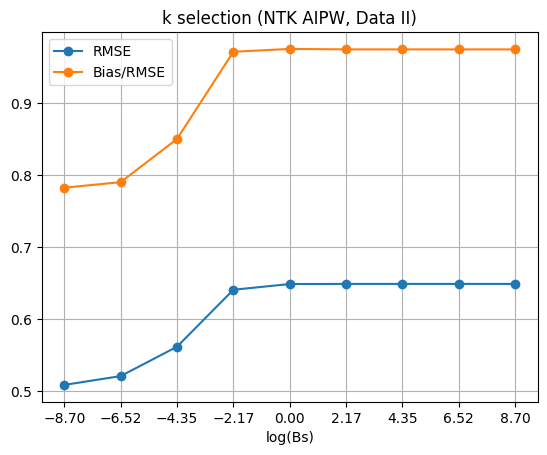

In [119]:
plt.plot(np.log(Bsv), rmses, marker='o', label='RMSE')
plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
plt.title('k selection (NTK AIPW, Data II)')
plt.xlabel('log(Bs)')
plt.xticks(np.log(Bsv))
plt.grid()
plt.legend()
plt.show()


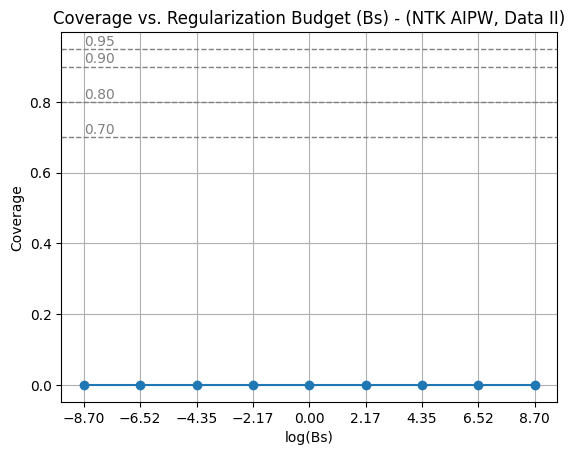

In [120]:
#coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK AIPW, Data II)')
plt.grid(True)
plt.xticks(np.log(Bsv))

plt.show()

# Data 3

In [121]:

from scipy.signal import convolve2d
filter = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

n = 5216
H, W = 224, 224
filtered_features = np.zeros((n, H, W))

def filter_image(image):
    return convolve2d(image, filter, mode='same', boundary='fill', fillvalue=0)

for i in tqdm(range(n)):
    img = df_combined['image_array'][i]  # assume shape (224, 224)
    filtered_img = filter_image(img)
    filtered_features[i] = filtered_img**2  # store squared filtered image

print(filtered_features.shape)

def brightness_f(x):
  return np.array([np.mean(i) for i in x])


X_filter = brightness_f(filtered_features)
mu = np.mean(X_filter)
print(X_filter.shape)

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/500)*(x-mu)) 

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  # seeding
  np.random.seed(0)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0



P, W, Y1, Y0 = assign(X_filter)

df_combined['W'] = W
df_combined['Y1'] = Y1
df_combined['Y0'] = Y0
df_combined['Y'] = df_combined['W'] * df_combined['Y1'] + (1 - df_combined['W']) * df_combined['Y0']

df_control = df_combined[df_combined['W'] == 0]
df_treated = df_combined[df_combined['W'] == 1]
X_full = np.array([np.array(x) for x in filtered_features])
y_full = df_combined['Y'].values
X_control = np.array([np.array(x) for x in filtered_features[df_control.index]])
y_control = df_control['Y'].values
X_treated = np.array([np.array(x) for x in filtered_features[df_treated.index]])
y_treated = df_treated['Y'].values

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


100%|██████████| 5216/5216 [00:08<00:00, 617.43it/s]


(5216, 224, 224)
(5216,)


In [122]:
set_seed(0)

def modeling():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# train and test the model
X_contol = X_control.reshape(X_control.shape[0], 224, 224, 1)
model_control = modeling()
model_control.fit(X_contol, y_control, epochs=5, batch_size=16, validation_split=0.2)

X_treated = X_treated.reshape(X_treated.shape[0], 224, 224, 1)
model_treated = modeling()
model_treated.fit(X_treated, y_treated, epochs=5, batch_size=16, validation_split=0.2)

X_full = X_full.reshape(X_full.shape[0], 224, 224, 1)
model_full = modeling()
model_full.fit(X_full, y_full, epochs=5, batch_size=16, validation_split=0.2)

y_pred = model_full.predict(X_full)
y_pred_control = model_control.predict(X_full)
y_pred_treated = model_treated.predict(X_full)
y_pred = y_pred.flatten()
y_pred_control = y_pred_control.flatten()
y_pred_treated = y_pred_treated.flatten()


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0448 - val_loss: 0.0470
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0151 - val_loss: 0.0065
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0096 - val_loss: 0.0035
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0073 - val_loss: 0.0026
Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.6569 - val_loss: 0.0906
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0247 - val_loss: 0.0140
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0171 - val_loss: 0.0088
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0143 - val_loss: 0.0082
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0129 - val_loss: 0.0073
Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - loss: 0.4447 - val_loss: 0.2037
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/st

In [123]:
N = 5216
def grad(X, model):
    X_i = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
        prediction = model(X_i, training=True)
    gradients = tape.gradient(prediction, model.trainable_variables)
    gradient_vector = np.concatenate([g.numpy().flatten() for g in gradients if g is not None])
    return gradient_vector


f0_grads = [grad(X_full[i:i+1], model_control) for i in tqdm(range(N))]
f1_grads = [grad(X_full[i:i+1], model_treated) for i in tqdm(range(N))]

n_s = 200
np.random.seed(0)
sidx = np.random.choice(N, n_s, replace=False)
f0_sampled_grads = [f0_grads[i] for i in sidx]
f1_sampled_grads = [f1_grads[i] for i in sidx]
W_sampled = W[sidx]

def f0_sampled(i):
    return f0_sampled_grads[i]

def f1_sampled(i):
    return f1_sampled_grads[i]

def K_sampled(i, j):
    if W_sampled[i] == 0 and W_sampled[j] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    elif W_sampled[i] == 1 and W_sampled[j] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

def K_diff_f0_sampled(i, j):
    if W_sampled[i] == 0:
        return f0_sampled(i) @ f0_sampled(j).T
    else:
        return 0

def K_diff_f1_sampled(i, j):
    if W_sampled[i] == 1:
        return f1_sampled(i) @ f1_sampled(j).T
    else:
        return 0

K_sampled_XX = np.zeros((n_s, n_s))
K_sampled_TT = np.zeros((n_s, n_s))
K_sampled_CC = np.zeros((n_s, n_s))

for i in range(n_s):
    for j in range(n_s):
        K_sampled_XX[i, j] = K_sampled(i, j)
        K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
        K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)



100%|██████████| 5216/5216 [01:44<00:00, 49.96it/s]


In [124]:
I = np.eye(n_s)
lambda1 = 900

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

Wp = np.array([W[i] for i in sidx])
Y1p = np.array([Y1[i] for i in sidx])
Y0p = np.array([Y0[i] for i in sidx])
Xp = np.array([X_filter[i] for i in sidx])

# IPW

# Compute IPW Estimate
Yp = Wp * Y1p + (1 - Wp) * Y0p
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)



IPW estimate: 0.8417854573179312


(-40.0, 40.0)

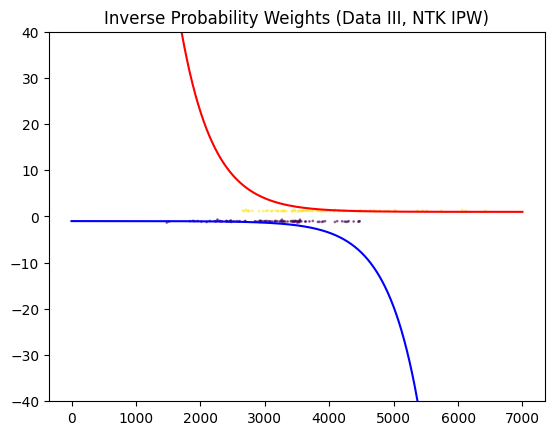

In [125]:
x = np.array(range(0,7000))
plt.scatter(Xp, gamma_ntk, c = Wp,alpha = .5, s = 1)
plt.plot(x, 1/(propensity_score(x)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
plt.title('Inverse Probability Weights (Data III, NTK IPW)')
plt.ylim(-40,40)

In [126]:
lambda1 =27000

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_ntk = (np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff)).flatten()

AIPW = np.mean(y_pred_treated[sidx] - y_pred_control[sidx])+np.mean(gamma_ntk * (Yp - y_pred[sidx]))

print("AIPW estimate:", AIPW)

y_preds = np.array([y_pred[i] for i in sidx])
v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
v_hat = (1 / n_s**2) * np.sum(v_sum)
se_hat = np.sqrt(v_hat)
print("Standard error estimate:", se_hat)

AIPW estimate: 1.0049653462123889
Standard error estimate: 0.002639790249343448


(-40.0, 40.0)

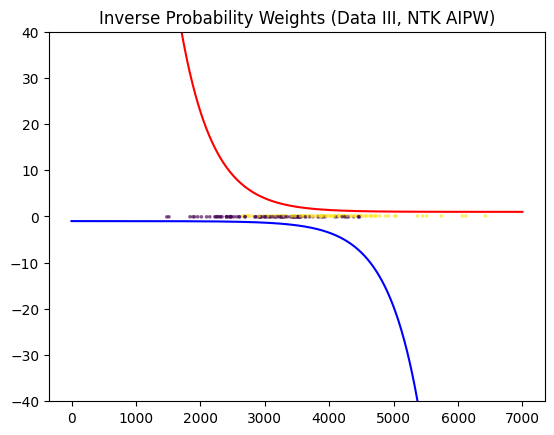

In [127]:
x = np.array(range(0,7000))
plt.scatter(Xp, gamma_ntk, c = Wp,alpha = .5, s = 3)
plt.plot(x, 1/(propensity_score(x)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
plt.title('Inverse Probability Weights (Data III, NTK AIPW)')
plt.ylim(-40,40)

In [128]:
n_s = 200
lambda1 = 900
ipw_estimates = []
se_hats = []

for seed in range(100):
    np.random.seed(seed)
    sidx = np.random.choice(N, n_s, replace=False)

    # Get sampled gradients and data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W[sidx]

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Compute optimal gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # Estimate IPW
    Wp = np.array([W[i] for i in sidx])
    Y1p = np.array([Y1[i] for i in sidx])
    Y0p = np.array([Y0[i] for i in sidx])
    Yp = Wp * Y1p + (1 - Wp) * Y0p

    ipw_estimate = np.mean(gamma_optimal * Yp)
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
    ipw_estimates.append(ipw_estimate)
    aipw_estimates.append(aipw_estimate)

    y_preds = np.array([y_pred[i] for i in sidx])
    v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_hats.append(se_hat)

samplestd_ipw = np.std(ipw_estimates)
samplestd_aipw = np.std(aipw_estimates)
exp_se = np.mean(se_hats)
exp_pes = np.mean(ipw_estimates)
true_arm_l, true_arm_r = 1 - 1.96*samplestd_ipw, 1+1.96*samplestd_ipw
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_flags_aipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
coverage_ipw = np.mean(coverage_flags_ipw)
coverage_aipw = np.mean(coverage_flags_aipw)

print("sample sd of IPW estimates:", samplestd_ipw)
print("sample sd of AIPW estimates:", samplestd_aipw)
print("Mean standard error estimate:", exp_se)
print("Coverage of confidence intervals:", coverage_ipw)
print("Coverage of AIPW confidence intervals:", coverage_aipw)
print("Mean IPW estimate:", exp_pes)
print("Mean AIPW estimate:", np.mean(aipw_estimates))


sample sd of IPW estimates: 0.04360203175650241
sample sd of AIPW estimates: 0.27845832081042843
Mean standard error estimate: 0.002727746202269458
Coverage of confidence intervals: 0.09
Coverage of AIPW confidence intervals: 0.105
Mean IPW estimate: 0.8487278231036233
Mean AIPW estimate: 1.1171502765703505


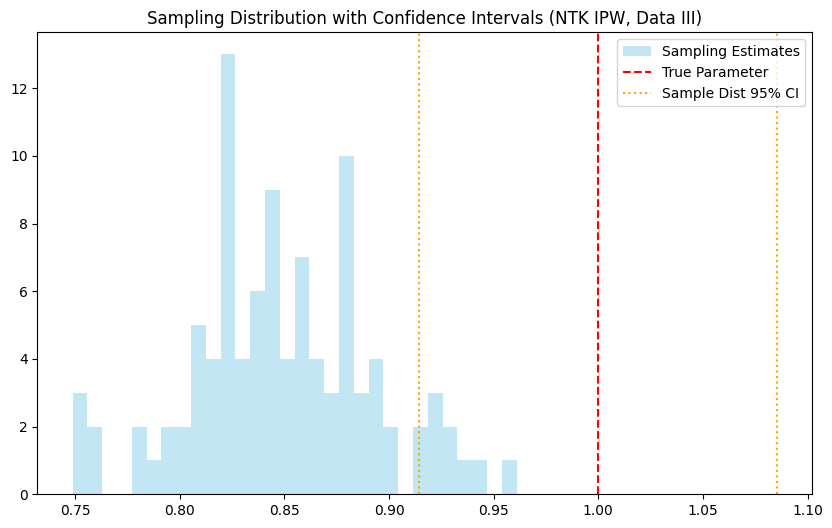

In [129]:
plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')

#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Sampling Distribution with Confidence Intervals (NTK IPW, Data III)')

plt.legend()
plt.show()

In [130]:
n_s = 200
lambda1 = 27000
aipw_estimates = []
se_hats = []

for seed in range(100):
    np.random.seed(seed)
    sidx = np.random.choice(N, n_s, replace=False)

    # Get sampled gradients and data
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W[sidx]

    # Compute kernel matrices
    K_sampled_XX = np.zeros((n_s, n_s))
    K_sampled_TT = np.zeros((n_s, n_s))
    K_sampled_CC = np.zeros((n_s, n_s))

    for i in range(n_s):
        for j in range(n_s):
            K_sampled_XX[i, j] = K_sampled(i, j)
            K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
            K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

    K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)

    # Compute optimal gamma
    I = np.eye(n_s)
    gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

    # Estimate IPW
    Wp = np.array([W[i] for i in sidx])
    Y1p = np.array([Y1[i] for i in sidx])
    Y0p = np.array([Y0[i] for i in sidx])
    Yp = Wp * Y1p + (1 - Wp) * Y0p

    #ipw_estimate = np.mean(gamma_optimal * Yp)
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
    #ipw_estimates.append(ipw_estimate)
    aipw_estimates.append(aipw_estimate)

    y_preds = np.array([y_pred[i] for i in sidx])
    v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
    v_hat = (1 / n_s**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_hats.append(se_hat)

#samplestd_ipw = np.std(ipw_estimates)
samplestd_aipw = np.std(aipw_estimates)
exp_se = np.mean(se_hats)
#exp_pes = np.mean(ipw_estimates)
true_arm_l, true_arm_r = 1 - 1.96*samplestd_aipw, 1+1.96*samplestd_aipw
#coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage_flags_aipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
#coverage_ipw = np.mean(coverage_flags_ipw)
coverage_aipw = np.mean(coverage_flags_aipw)

#print("sample sd of IPW estimates:", samplestd_ipw)
print("sample sd of AIPW estimates:", samplestd_aipw)
print("Mean standard error estimate:", exp_se)
#print("Coverage of confidence intervals:", coverage_ipw)
print("Coverage of AIPW confidence intervals:", coverage_aipw)
#print("Mean IPW estimate:", exp_pes)
print("Mean AIPW estimate:", np.mean(aipw_estimates))


sample sd of AIPW estimates: 0.004114591015722975
Mean standard error estimate: 0.002727746202269458
Coverage of AIPW confidence intervals: 0.81
Mean AIPW estimate: 1.0043771661703476


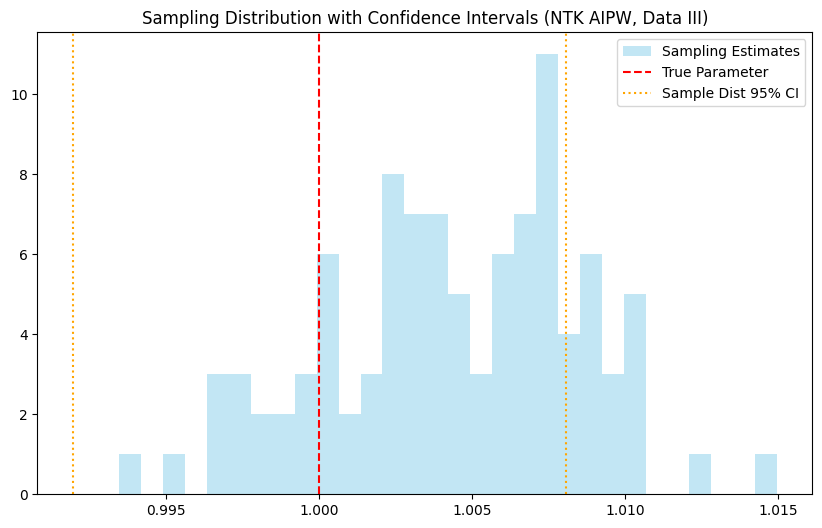

In [131]:
plt.figure(figsize=(10, 6))
plt.hist(aipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
#plt.hist(aipw_estimates, bins=30, alpha=0.5, color='lightgreen', label='AIPW Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(ipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)
# for i, (point_est, std) in enumerate(zip(aipw_estimates, se_hats)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='green', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Sampling Distribution with Confidence Intervals (NTK AIPW, Data III)')

plt.legend()
plt.show()

In [132]:
n_s = 200
sesipw = []
sesaipw = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigma = 1
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]  

for k in k_values:
    
    ipw_estimates = []
    se_hats = []
    Bs = ps ** k
    Bsv.append(Bs)

    lambda1 = sigma**2/(Bs**2 * n_s**2)


    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(N, n_s, replace=False)

        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W[sidx]

        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        Wp = np.array([W[i] for i in sidx])
        Y1p = np.array([Y1[i] for i in sidx])
        Y0p = np.array([Y0[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        ipw_estimate = np.mean(gamma_optimal * Yp)
        #aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))

        ipw_estimates.append(ipw_estimate)
        #aipw_estimates.append(aipw_estimate)

        y_preds = y_pred[sidx]
        v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    samplestd_ipw = np.std(ipw_estimates)
    #samplestd_aipw = np.std(aipw_estimates)
    exp_se = np.mean(se_hats)
    mean_ipw = np.mean(ipw_estimates)
    #mean_aipw = np.mean(aipw_estimates)
    true_arm_l, true_arm_r = 1 - 1.96 * samplestd_ipw, 1 + 1.96 * samplestd_ipw
    #coverage_aipw = np.mean([(true_arm_l <= est <= true_arm_r) for est in aipw_estimates])
    rmse = np.sqrt(np.mean((np.array(ipw_estimates) - true)**2))
    bias = np.abs(np.mean(ipw_estimates) - true)
    coverage = np.mean([(true_arm_l <= est <= true_arm_r) for est in ipw_estimates])
    biasv.append(bias)
    rmses.append(rmse)
    coveragev.append(coverage)
    

    print('k:', k)
    print('lambda:', lambda1)
    #print('coverage ipw:', coverage_ipw)
    #print('coverage aipw:', coverage_aipw)
    print('sample std ipw:', samplestd_ipw)
    #print('sample std aipw:', samplestd_aipw)
    print('expected ipw:', mean_ipw)
    #print('expected aipw:', mean_aipw)
    print('expected se:', exp_se)
    print('coverage ipw:', coverage_ipw)
    print('---')

    sesipw.append(samplestd_ipw)

    #sesaipw.append(samplestd_aipw)


k: -1
lambda: 900.0
sample std ipw: 0.04360203175650241
expected ipw: 0.8487278231036233
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: -0.75
lambda: 11.618950038622252
sample std ipw: 0.0356335262813017
expected ipw: 1.2930849721421176
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: -0.5
lambda: 0.15000000000000002
sample std ipw: 0.03649843228059624
expected ipw: 1.21176706650977
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: -0.25
lambda: 0.0019364916731037087
sample std ipw: 0.04648393564144022
expected ipw: 1.157680096246122
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: 0
lambda: 2.5e-05
sample std ipw: 0.04841345765626405
expected ipw: 1.1537857297993772
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: 0.25
lambda: 3.227486121839514e-07
sample std ipw: 0.048459076501086745
expected ipw: 1.1537403465348004
expected se: 0.002727746202269458
coverage ipw: 0.09
---
k: 0.5
lambda: 4.166666666666667e-09
sample std ipw: 0.04

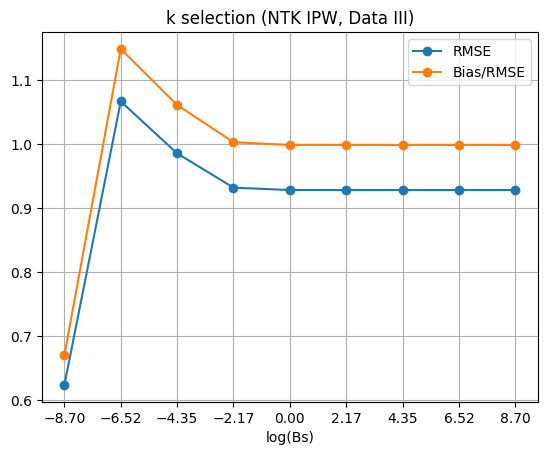

In [133]:
plt.plot(np.log(Bsv), rmses, marker='o', label='RMSE')
plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
plt.title('k selection (NTK IPW, Data III)')
plt.xlabel('log(Bs)')
plt.xticks(np.log(Bsv))
plt.grid()
plt.legend()
plt.show()


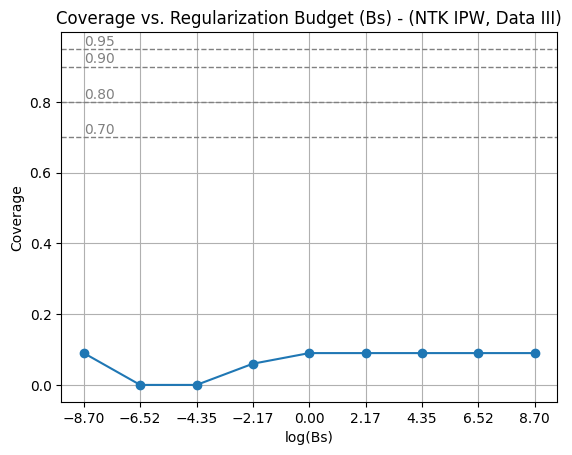

In [134]:
# coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK IPW, Data III)')
plt.grid(True)
plt.xticks(np.log(Bsv))
plt.show()


In [135]:
n_s = 200
sesaipw = []
rmses = []
biasv = []
Bsv = []
coveragev = []
ps = 6000
sigmasquared = 30
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]  

for k in k_values:
    
    aipw_estimates = []
    se_hats = []
    Bs = ps ** k
    Bsv.append(Bs)

    lambda1 = sigmasquared/(Bs**2 * n_s**2)

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(N, n_s, replace=False)

        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W[sidx]

        K_sampled_XX = np.zeros((n_s, n_s))
        K_sampled_TT = np.zeros((n_s, n_s))
        K_sampled_CC = np.zeros((n_s, n_s))

        for i in range(n_s):
            for j in range(n_s):
                K_sampled_XX[i, j] = K_sampled(i, j)
                K_sampled_TT[i, j] = K_diff_f1_sampled(i, j)
                K_sampled_CC[i, j] = K_diff_f0_sampled(i, j)

        K_sampled_diff = np.sum(K_sampled_TT, axis=1) - np.sum(K_sampled_CC, axis=1)
        I = np.eye(n_s)
        gamma_optimal = np.linalg.solve(K_sampled_XX + lambda1 * I, K_sampled_diff).flatten()

        Wp = np.array([W[i] for i in sidx])
        Y1p = np.array([Y1[i] for i in sidx])
        Y0p = np.array([Y0[i] for i in sidx])
        Yp = Wp * Y1p + (1 - Wp) * Y0p

        
        aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_optimal * (Yp - y_pred[sidx]))
        aipw_estimates.append(aipw_estimate)

        y_preds = y_pred[sidx]
        v_sum = gamma_ntk**2 * (Yp - y_preds) ** 2
        v_hat = (1 / n_s**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_hats.append(se_hat)

    
    samplestd_aipw = np.std(aipw_estimates)
    exp_se = np.mean(se_hats)
    mean_aipw = np.mean(aipw_estimates)
    true_arm_l, true_arm_r = 1 - 1.96 * samplestd_aipw, 1 + 1.96 * samplestd_aipw
    coverage_aipw = np.mean([(true_arm_l <= est <= true_arm_r) for est in aipw_estimates])
    rmse = np.sqrt(np.mean((np.array(aipw_estimates) - true)**2))
    bias = np.abs(np.mean(aipw_estimates) - true)
    coverage = np.mean([(true_arm_l <= est <= true_arm_r) for est in aipw_estimates])

    biasv.append(bias)
    rmses.append(rmse)
    coveragev.append(coverage)
    

    print('k:', k)
    print('lambda:', lambda1)
    print('sample std ipw:', samplestd_aipw)
    print('expected ipw:', mean_aipw)
    print('expected se:', exp_se)
    print('coverage ipw:', coverage)
    print('---')


    #sesaipw.append(samplestd_aipw)


k: -1
lambda: 27000.0
sample std ipw: 0.004114591015722975
expected ipw: 1.0043771661703476
expected se: 0.002727746202269458
coverage ipw: 0.81
---
k: -0.75
lambda: 348.5685011586676
sample std ipw: 0.029348683781724925
expected ipw: 1.520471731516129
expected se: 0.002727746202269458
coverage ipw: 0.0
---
k: -0.5
lambda: 4.5
sample std ipw: 0.03312020054536505
expected ipw: 1.7281125803351793
expected se: 0.002727746202269458
coverage ipw: 0.0
---
k: -0.25
lambda: 0.05809475019311126
sample std ipw: 0.03380015348792344
expected ipw: 1.8255519287589101
expected se: 0.002727746202269458
coverage ipw: 0.0
---
k: 0
lambda: 0.00075
sample std ipw: 0.042345800814750076
expected ipw: 1.8529650213672115
expected se: 0.002727746202269458
coverage ipw: 0.0
---
k: 0.25
lambda: 9.682458365518543e-06
sample std ipw: 0.04328228783034011
expected ipw: 1.8537903404748173
expected se: 0.002727746202269458
coverage ipw: 0.0
---
k: 0.5
lambda: 1.25e-07
sample std ipw: 0.04330105993168048
expected ipw: 

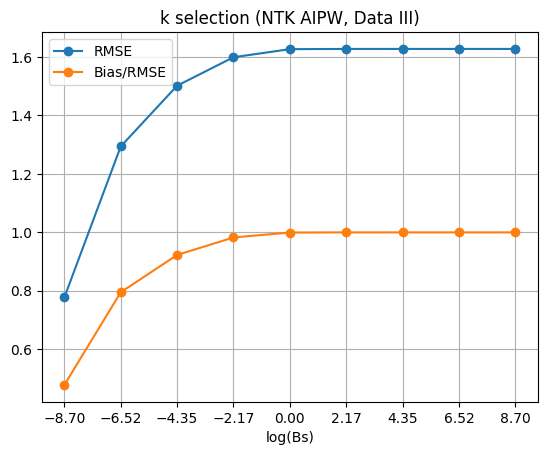

In [136]:
plt.plot(np.log(Bsv), rmses, marker='o', label='RMSE')
plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
plt.title('k selection (NTK AIPW, Data III)')
plt.xlabel('log(Bs)')
plt.xticks(np.log(Bsv))
plt.grid()
plt.legend()
plt.show()


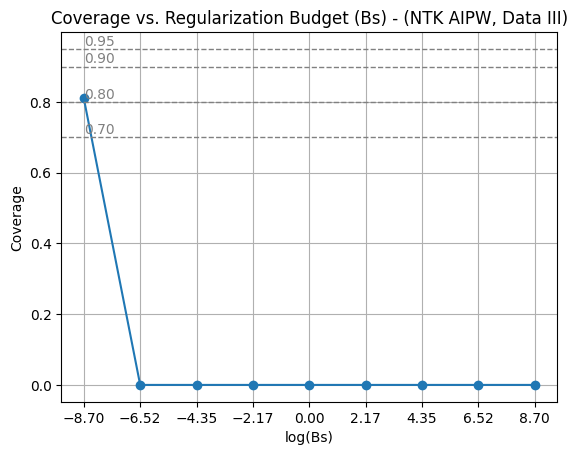

In [137]:
# cpverage

plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('log(Bs)')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK AIPW, Data III)')
plt.grid(True)
plt.xticks(np.log(Bsv))
plt.show()